<a href="https://colab.research.google.com/github/gpdbs9409/DAP/blob/main/%5BLab_session_7%5DTime_Series_Data_Processing_ipynb%EC%9D%98_%EC%82%AC%EB%B3%B8.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Bitcoin data
In this lab, we would like to explore *Time-Series* data about Bitcoin price.

Since the data is acquired too frequently, we would like to downsample the data to have a value only once in a week. Please refer the [documents](https://rfriend.tistory.com/494) of `resample().mean()` method.


In [5]:
from dateutil.parser import parse
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd
plt.rcParams.update({'figure.figsize': (10, 7),
                     'figure.dpi': 120})

# Import as Dataframe
df_original = pd.read_csv('https://raw.githubusercontent.com/choi-hyunsoo/DAP/main/coin_Bitcoin.csv',
                 parse_dates=['Date']).set_index('Date')
df_original = df_original.resample("1W").mean()
df_original.head()

<ipython-input-5-47062300aef2>:13: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  df_original = df_original.resample("1W").mean()


,SNo,High,Low,Open,Close,Volume,Marketcap
Date,,,,,,,
2013-05-05,4.0,128.833714,106.684986,121.582000,118.842856,0.0,1.319866e+09
2013-05-12,11.0,117.925000,108.742286,113.881286,113.925571,0.0,1.268553e+09
2013-05-19,18.0,121.159858,114.127428,117.620143,118.709001,0.0,1.325205e+09
2013-05-26,25.0,128.660714,124.523429,126.085143,127.732712,0.0,1.429371e+09
2013-06-02,32.0,131.423569,124.801571,130.204858,128.633714,0.0,1.443233e+09


In [ ]:
df=df_original.copy()

# Draw Plot

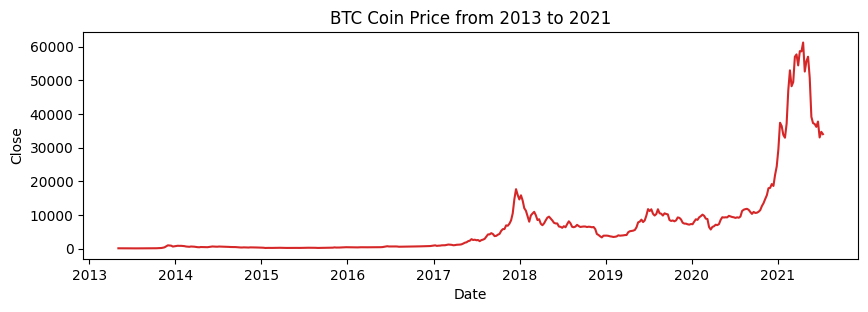

In [ ]:
def plot_df(x, y, title="", xlabel='Date', ylabel='Close', dpi=100):
    plt.figure(figsize=(10,3), dpi=dpi)
    plt.plot(x, y, color='tab:red')
    plt.gca().set(title=title, xlabel=xlabel, ylabel=ylabel)
    plt.show()

plot_df(x=df.index, y=df.Close,
        title='BTC Coin Price from 2013 to 2021')

**[TODO]** Draw `Year-wise Box Plot` and `Month-wise Box Plot`.

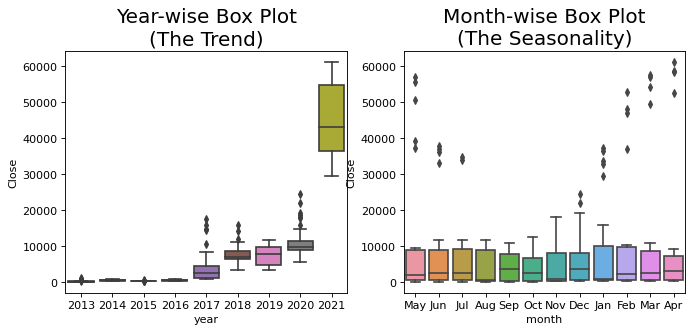

In [ ]:
# Prepare data
df['year'] = [d.year for d in df.index]
df['month'] = [d.strftime('%b') for d in df.index]
years = df['year'].unique()

# Draw Plot
fig, axes = plt.subplots(1, 2, figsize=(10,4), dpi= 80)
sns.boxplot(x=df['year'], y=df.Close, data=df,ax=axes[0])
sns.boxplot(x=df['month'], y=df.Close,data=df)

# Set Title
axes[0].set_title('Year-wise Box Plot\n(The Trend)', fontsize=18);
axes[1].set_title('Month-wise Box Plot\n(The Seasonality)', fontsize=18)
plt.show()

Decomposite the data into Trend, Seasonal, Residual using `seasonal_decompose`.

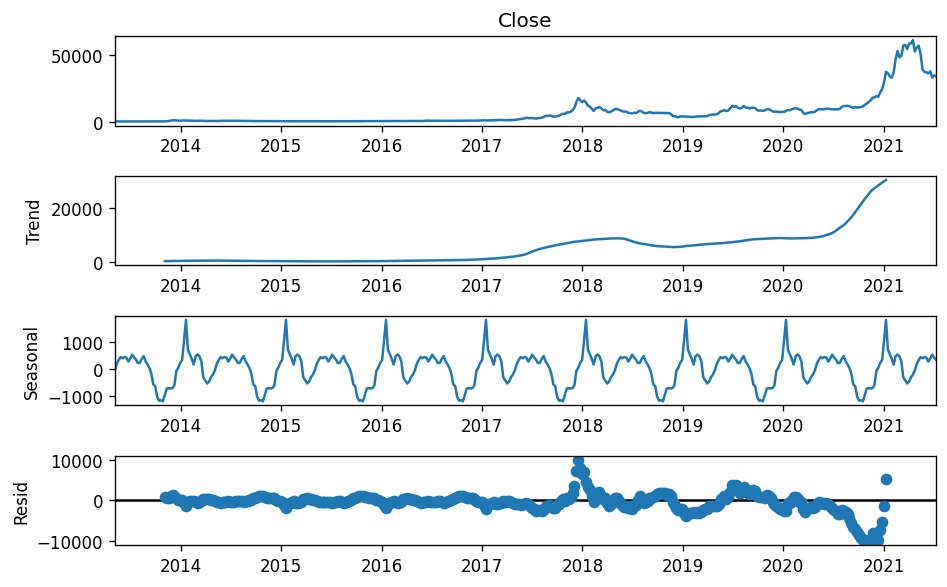

In [ ]:
from statsmodels.tsa.seasonal import seasonal_decompose
from dateutil.parser import parse

# Decomposition
decompositionResult = seasonal_decompose(df.Close)

# Plot
plt.rcParams.update({'figure.figsize': (8,5)})
decompositionResult.plot()
plt.show()

# Interpolation
Due to some errors in databes, the data of the first quater is lost. So we would like to guess the value using interpolation.

In [ ]:
# Generate the missing data
df_missing = df.copy()
df_missing[(df.index.month <= 3)] = np.nan

**[TODO]** Forward and Backward Fill loss seems to be not proper. Please apply Linear Interpolation.

In [ ]:
from scipy.interpolate import interp1d

# Forward Fill
df_ffill = df_missing.ffill()

# Backward Fill
df_bfill = df_missing.bfill()

# Linear Interpolation
df_lfill = df_missing.copy()
df_missing['rownum'] = np.arange(df_missing.shape[0])
df_missing_nona = df_missing.dropna(subset=['Close'])
f = interp1d(df_missing_nona['rownum'], df_missing_nona['Close'])

df_lfill.Close = f(df_missing['rownum'])


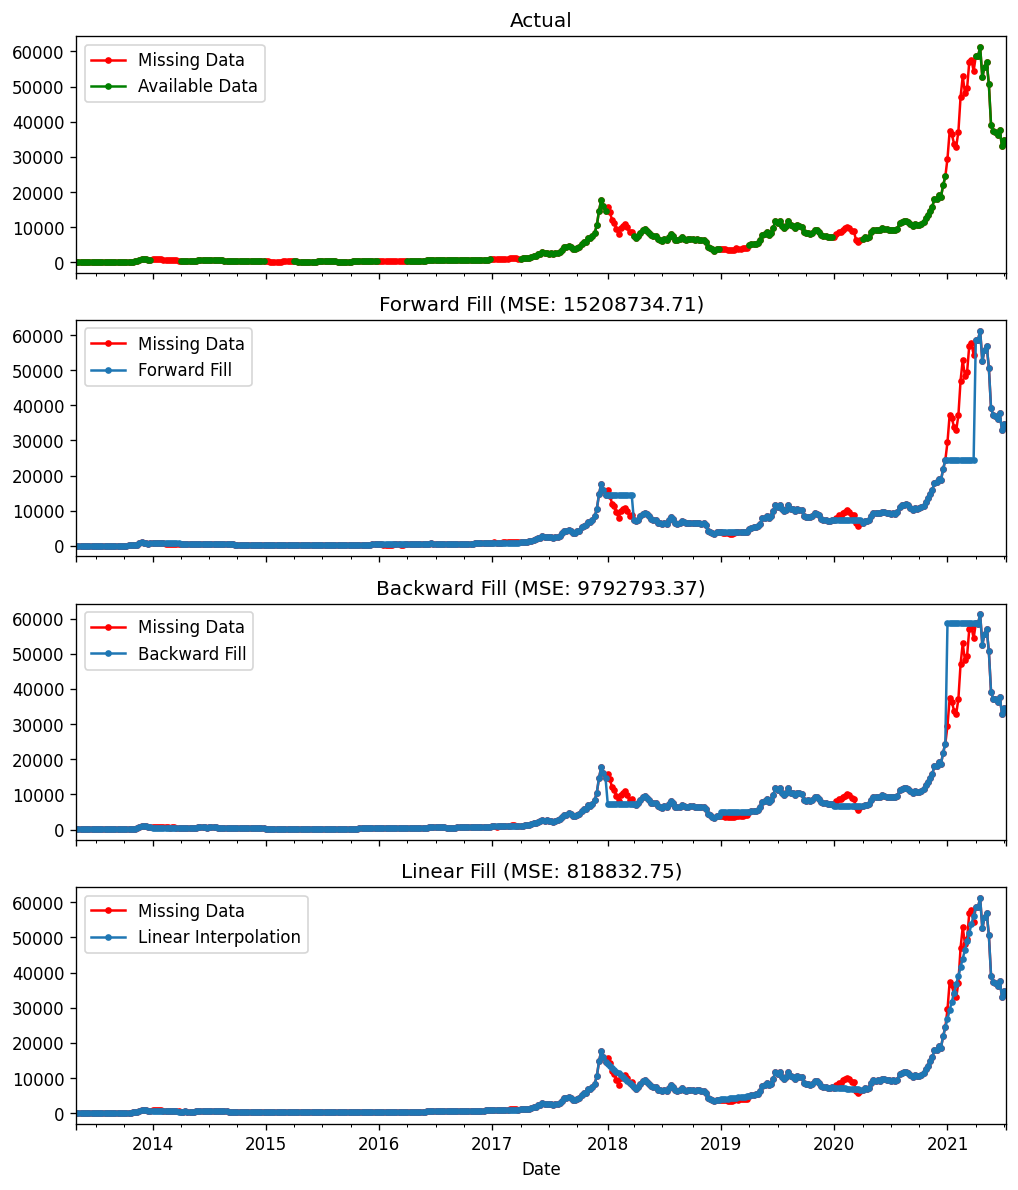

In [ ]:
# Calculate Error
from sklearn.metrics import mean_squared_error

error_ffill = np.round(mean_squared_error(df['Close'], df_ffill['Close']), 2)
error_bfill = np.round(mean_squared_error(df['Close'], df_bfill['Close']), 2)
error_lfill = np.round(mean_squared_error(df['Close'], df_lfill['Close']), 2)


# Plotting
fig, axes = plt.subplots(4, 1, sharex=True, figsize=(10, 12))
plt.rcParams.update({'xtick.bottom' : False})

for ax in axes:
  df.Close.plot(title='Actual', ax=ax, label='Actual', color='red', style=".-")

df_missing.Close.plot(title='Actual', ax=axes[0], label='Actual', color='green', style=".-")
df_ffill.Close.plot(title='Forward Fill (MSE: ' + str(error_ffill) +")", ax=axes[1],
                       label='Forward Fill', style=".-")
df_bfill.Close.plot(title="Backward Fill (MSE: " + str(error_bfill) +")", ax=axes[2],
                       label='Back Fill', style=".-")
df_lfill.Close.plot(title="Linear Fill (MSE: " + str(error_lfill) +")",
                       ax=axes[3], label='Cubic Fill', style=".-")


# Add legend
methods = ['Available Data', 'Forward Fill',
           'Backward Fill', 'Linear Interpolation']
for ax, mt in zip(axes, methods):
  ax.legend(["Missing Data", mt])


# Interpolation References:
# https://docs.scipy.org/doc/scipy/reference/tutorial/interpolate.html
# https://docs.scipy.org/doc/scipy/reference/interpolate.html

# Smoothing

In [18]:
from statsmodels.nonparametric.smoothers_lowess import lowess
plt.rcParams.update({'xtick.bottom' : False, 'axes.titlepad':5})

# 1. Moving Average
df_ma = df.Close.rolling(30).mean()

# 2. Loess Smoothing (5% and 15%)
df_loess_5 = pd.DataFrame(
    lowess(df.Close, np.arange(len(df.Close)), frac=0.05)[:, 1],
    index=df.index, columns=['Close'])

df_loess_15 = pd.DataFrame(
    lowess(df.Close, np.arange(len(df.Close)), frac=0.15)[:, 1],
    index=df.index, columns=['Close'])

# Plot
fig, axes = plt.subplots(4,1, figsize=(7, 7), sharex=True, dpi=120)

df['Close'].plot(ax=axes[0], color='k', title='Original Series')
df_ma.plot(ax=axes[1], title='Moving Average (10)')
df_loess_5['Close'].plot(ax=axes[2], title='Loess Smoothed 5%')
df_loess_15['Close'].plot(ax=axes[3], title='Loess Smoothed 15%')

fig.suptitle('How to Smoothen a Time Series', y=0.95, fontsize=14)
plt.show()

AttributeError: ignored

#TODO
### 춘천 날씨데이터
 - 2001년부터 2022년까지의 날씨 데이터를 이용해보겠습니다.

In [19]:
df = pd.read_excel('https://github.com/wonseok-hong/DAP_TA/blob/main/weather_cc.xlsx?raw=true',
                    parse_dates=['Date']).set_index('Date')
df

,City,Average Temperature,Average Highest Temperature,Highest Temperature,Average Lowest emperature,Lowest Temperature
Date,,,,,,
2001-01-01,춘천,-6.7,-1.0,7.3,-12.3,-24.5
2001-02-01,춘천,-2.5,4.0,13.5,-8.2,-18.6
2001-03-01,춘천,3.3,10.3,22.1,-2.7,-7.6
2001-04-01,춘천,12.3,20.8,28.0,3.9,-4.1
2001-05-01,춘천,18.8,26.5,32.9,11.7,6.1
...,...,...,...,...,...,...
2022-06-01,춘천,22.6,27.4,34.8,18.3,10.5
2022-07-01,춘천,26.6,31.3,35.3,23.0,20.4
2022-08-01,춘천,25.2,29.0,33.3,22.1,13.7


In [17]:
print(df.columns)

Index(['City', 'Average Temperature', 'Average Highest Temperature',
       'Highest Temperature', 'Average Lowest emperature',
       'Lowest Temperature'],
      dtype='object')


###1. 데이터 drop시키기
연도별로 데이터가 1월부터 12월까지 존재하지만 `2022년`은 `10월 이후의 값`들이 존재하지 않습니다. 게다가 10월에는 결측값들이 발견됩니다.

`2022년`의 데이터를 `drop`시켜주세요!

In [8]:
df_ri=  df.reset_index()
df_ri['year'] = [d.year for d in df_ri.Date]


index_2022= df_ri[df_ri['year']==2022].index
df_ri=df_ri.drop(index_2022)
df_ri

,Date,City,Average Temperature,Average Highest Temperature,Highest Temperature,Average Lowest emperature,Lowest Temperature,year
0,2001-01-01,춘천,-6.7,-1.0,7.3,-12.3,-24.5,2001
1,2001-02-01,춘천,-2.5,4.0,13.5,-8.2,-18.6,2001
2,2001-03-01,춘천,3.3,10.3,22.1,-2.7,-7.6,2001
3,2001-04-01,춘천,12.3,20.8,28.0,3.9,-4.1,2001
4,2001-05-01,춘천,18.8,26.5,32.9,11.7,6.1,2001
...,...,...,...,...,...,...,...,...
247,2021-08-01,춘천,24.9,29.5,34.3,21.5,17.4,2021
248,2021-09-01,춘천,21.3,26.7,30.1,17.2,14.9,2021
249,2021-10-01,춘천,14.0,20.0,28.5,9.5,-1.2,2021
250,2021-11-01,춘천,6.3,12.8,20.6,1.2,-5.6,2021


### 2. box plot으로 표현하기
`Average Temperature`의 `Trend`와 `Seasonality`를 boxplot으로 나타내세요

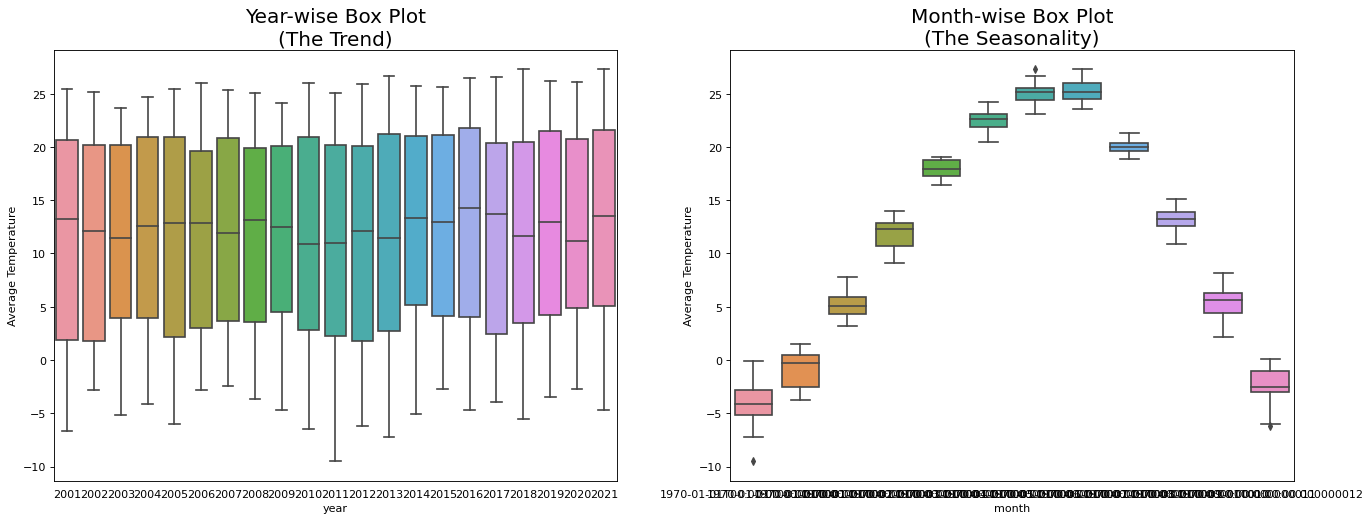

In [22]:
df_ri['month'] =pd.to_datetime(df_ri['Date'].dt.month)

fig, axes = plt.subplots(1,2,figsize=(20,7), dpi=80)
sns.boxplot(x='year',y='Average Temperature', data=df_ri,ax=axes[0])
sns.boxplot(x='month',y='Average Temperature',data=df_ri,ax=axes[1])

axes[0].set_title('Year-wise Box Plot\n(The Trend)', fontsize=18);
axes[1].set_title('Month-wise Box Plot\n(The Seasonality)', fontsize=18)


plt.show()

### 3. 결측값 만들어주기
- 10월,11월,12월의 값을 `NaN`값으로 만들어주세요

In [21]:
df_nan = df.copy()
df_nan['month'] = df_nan.index.month
df_nan.loc[df_nan['month'].isin([10,11,12]),'month']=np.nan
df_nan

,City,Average Temperature,Average Highest Temperature,Highest Temperature,Average Lowest emperature,Lowest Temperature,month
Date,,,,,,,
2001-01-01,춘천,-6.7,-1.0,7.3,-12.3,-24.5,1.0
2001-02-01,춘천,-2.5,4.0,13.5,-8.2,-18.6,2.0
2001-03-01,춘천,3.3,10.3,22.1,-2.7,-7.6,3.0
2001-04-01,춘천,12.3,20.8,28.0,3.9,-4.1,4.0
2001-05-01,춘천,18.8,26.5,32.9,11.7,6.1,5.0
...,...,...,...,...,...,...,...
2022-06-01,춘천,22.6,27.4,34.8,18.3,10.5,6.0
2022-07-01,춘천,26.6,31.3,35.3,23.0,20.4,7.0
2022-08-01,춘천,25.2,29.0,33.3,22.1,13.7,8.0


## 4. Drop

- interpolation을 하기 위해서는 그래프가 `연속`이어야 합니다.
- df와 df_nan의 경우 마지막 2022-10-01의 값이 NaN값이기 때문에 df_nan과 df 둘 다 `2022-10-01`의값을 drop시켜주세요

In [24]:
df_nan.drop(pd.Timestamp('2022-10-01'), errors='ignore')
df.drop(pd.Timestamp('2022-10-01'), errors='ignore')
print(df_nan)
print(df)

           City  Average Temperature  Average Highest Temperature  \
Date                                                                
2001-01-01   춘천                 -6.7                         -1.0   
2001-02-01   춘천                 -2.5                          4.0   
2001-03-01   춘천                  3.3                         10.3   
2001-04-01   춘천                 12.3                         20.8   
2001-05-01   춘천                 18.8                         26.5   
...         ...                  ...                          ...   
2022-06-01   춘천                 22.6                         27.4   
2022-07-01   춘천                 26.6                         31.3   
2022-08-01   춘천                 25.2                         29.0   
2022-09-01   춘천                 20.5                         26.7   
2022-10-01   춘천                  NaN                          NaN   

            Highest Temperature  Average Lowest emperature  \
Date                                    

#5. Interpolation

- 결측치를 `quadratic`을 사용해서 채워주세요!
- `Lowest Temperature`에 대한 그래프를 그려주세요!

In [26]:
df_qfill = df.copy()
df_qfill['Lowest Temperature'] = df_qfill['Lowest Temperature'].interpolate(method='quadratic')
error_qfill = np.round(mean_squared_error(df['Lowest Temperature'].dropna(), df_qfill['Lowest Temperature']), 2)

# Calculate Error
error_qfill = np.round(mean_squared_error(df['Lowest Temperature'], df_qfill['Lowest Temperature']), 2)


# Plotting
fig, axes = plt.subplots(2, 1, sharex=True, figsize=(12, 5))
plt.rcParams.update({'xtick.bottom' : False})

for ax in axes:
  df['Lowest Temperature'].plot(title='Actual', ax=ax, label='Actual', color='red', style=".-")

df_nan['Lowest Temperature'].plot(title='Actual', ax=axes[0], label='Actual', color='green', style=".-")

df_qfill['Lowest Temperature'].plot(title="Quadratic Fill (MSE: " + str(error_qfill) +")",
                       label='Quadratic Fill', style=".-")



# Add legend
methods = ['Available Data',  'Quadratic Interpolation']
for ax, mt in zip(axes, methods):
  ax.legend(["Missing Data", mt])

NameError: ignored